## Parte 1: Crear un detector de belleza a partir de un dataset existente


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Obtener los datos para el modelo
* Link del dataset: https://drive.google.com/file/d/1w0TorBfTIqbquQVd6k3h_77ypnrvfGwf/view
* Ponerlo en la carpeta "datasets"

In [2]:
local_path = os.path.abspath("/home/rexcolt/GitHub/machine-learning-projects/facial-beauty-detection")

if os.path.isdir(local_path):
    print("Directorio local: ", local_path)
else:
    local_path = None

dataset_path = os.path.relpath("datasets/SCUT-FBP5500_v2")
if local_path:
    dataset_path = os.path.join(local_path, dataset_path)

csv_file_path = os.path.join(dataset_path, 'train_test_files', 'All_labels.txt')
images_path = os.path.join(dataset_path, 'Images')

models_path = os.path.relpath('models')
if local_path:
    models_path = os.path.join(local_path, models_path)

print(f"local_path: {local_path}")
print(f"dataset_path: {dataset_path}")
print(f"csv_file_path: {csv_file_path}")
print(f"images_path: {images_path}")
print(f"models_path: {models_path}")

Directorio local:  /home/rexcolt/GitHub/machine-learning-projects/facial-beauty-detection
local_path: /home/rexcolt/GitHub/machine-learning-projects/facial-beauty-detection
dataset_path: /home/rexcolt/GitHub/machine-learning-projects/facial-beauty-detection/datasets/SCUT-FBP5500_v2
csv_file_path: /home/rexcolt/GitHub/machine-learning-projects/facial-beauty-detection/datasets/SCUT-FBP5500_v2/train_test_files/All_labels.txt
images_path: /home/rexcolt/GitHub/machine-learning-projects/facial-beauty-detection/datasets/SCUT-FBP5500_v2/Images
models_path: /home/rexcolt/GitHub/machine-learning-projects/facial-beauty-detection/models


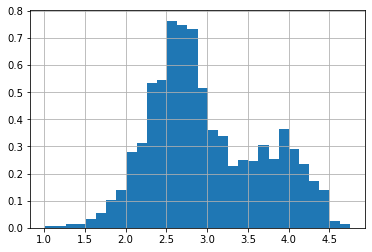

In [3]:
df = pd.read_csv(
    filepath_or_buffer=csv_file_path,
    sep=' ',
    names=['filename', 'rating']
)

# Primeros 5 renglones
# df.head()

# Describir el dataset
# df.describe()

# Histograma de rates
df.rating.hist(bins=30, density=1)

## 2. Configurar Keras

In [4]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras_preprocessing.image import ImageDataGenerator

# Crear un generador de batch
img_size = 224
batch_size = 32 # 64
validation_split = 0.2
training_steps_per_epoch = (len(df) * (1 - validation_split)) // batch_size
validation_steps = (len(df) * validation_split) // batch_size

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=validation_split
)

train_generator = datagen.flow_from_dataframe(
    subset='training',
    dataframe=df,
    directory=images_path,
    x_col='filename',
    y_col='rating',
    has_ext=True,
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_size, img_size),
    class_mode='other',
    interpolation='nearest'
)

validation_generator = datagen.flow_from_dataframe(
    subset='validation',
    dataframe=df,
    directory=images_path,
    x_col='filename',
    y_col='rating',
    has_ext=True,
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_size, img_size),
    class_mode='other',
    interpolation='nearest'
)

Found 4400 validated image filenames.
Found 1100 validated image filenames.


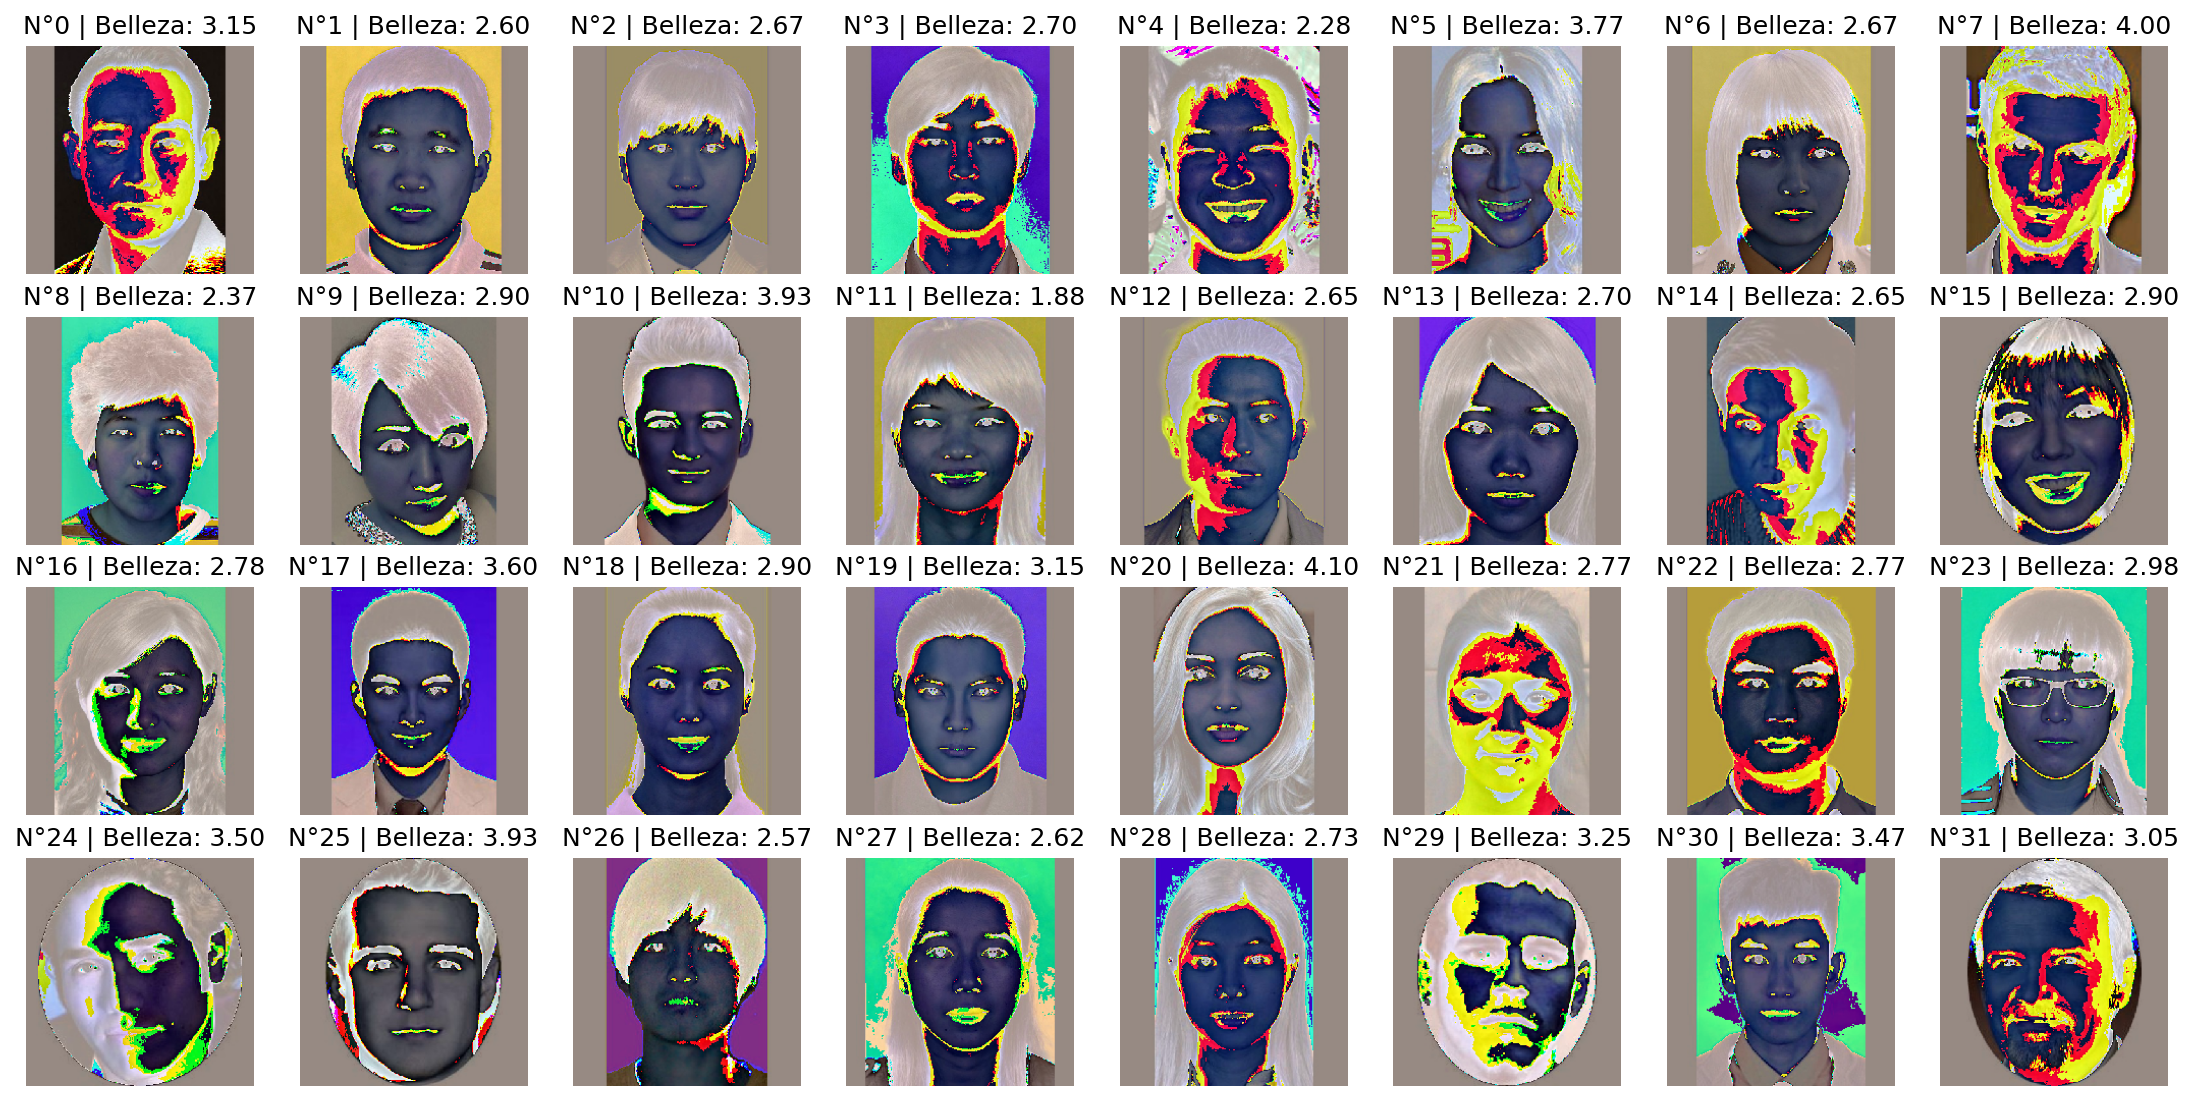

In [5]:
# Mostrar el dataset
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12,8), dpi=150)
plt.subplots_adjust(bottom=0, left=.01, right=1.2, top=0.9, hspace=.01)
for i, (image, label) in enumerate(zip(x_batch[:32], y_batch[:32])):
    plt.subplot(4, 8, i + 1)
    plt.axis('off')
    plt.imshow(image.astype(np.uint8))
    plt.title('N°%i | Belleza: %.2f' % (i, label))

### Creando la red neuronal
* Se utilizará la técnica de aprendizaje por transferencia
* El modelo pre-entrenado no tiene la última capa. Esta será una personalizada.
* Después, se entrenará solamente a esta última capa.

In [6]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout

model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

# 2nd layer
model.add(Dense(2, activation="relu", name="layer2"))

# 3rd layer for regression
model.add(Dense(3, activation="relu", name="layer3"))

# No entrenar a la primer capa (debido a que ya está entrenada)
model.layers[0].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
layer2 (Dense)               (None, 2)                 4098      
_________________________________________________________________
layer3 (Dense)               (None, 3)                 9         
Total params: 23,591,819
Trainable params: 4,107
Non-trainable params: 23,587,712
_________________________________________________________________


In [7]:
from keras.optimizers import Adam, SGD

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='mean_absolute_error')

## 3. Entrenando al modelo (yay)

In [8]:
import multiprocessing

n_workers = multiprocessing.cpu_count() - 1
print(f'Se tienen {multiprocessing.cpu_count()} CPUs físicos. Se usaran {n_workers} para el preprocesamiento.')

n_epochs = 50 # Se puede reducir para entrenar mas rapido

history = model.fit_generator(
    train_generator,
    epochs=n_epochs,
    steps_per_epoch=training_steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=validation_generator,
    max_queue_size=30,
    workers=n_workers,
    use_multiprocessing=False
)

# Guardar el modelo final
model.save(os.path.join(models_path, 'beauty_model_untuned.h5'))

Se tienen 4 CPUs físicos. Se usaran 3 para el preprocesamiento.
Epoch 1/50
137/137 [==============================] - 509s 4s/step - loss: 0.8908 - val_loss: 0.3729
Epoch 2/50
137/137 [==============================] - 479s 3s/step - loss: 0.3518 - val_loss: 0.3751
Epoch 3/50
137/137 [==============================] - 453s 3s/step - loss: 0.3293 - val_loss: 0.3582
Epoch 4/50
137/137 [==============================] - 439s 3s/step - loss: 0.3183 - val_loss: 0.3323
Epoch 5/50
137/137 [==============================] - 441s 3s/step - loss: 0.3186 - val_loss: 0.3311
Epoch 6/50
137/137 [==============================] - 439s 3s/step - loss: 0.3179 - val_loss: 0.3186
Epoch 7/50
137/137 [==============================] - 437s 3s/step - loss: 0.3041 - val_loss: 0.3141
Epoch 8/50
137/137 [==============================] - 437s 3s/step - loss: 0.3110 - val_loss: 0.3097
Epoch 9/50
137/137 [==============================] - 437s 3s/step - loss: 0.3009 - val_loss: 0.3075
Epoch 10/50
137/137 [======

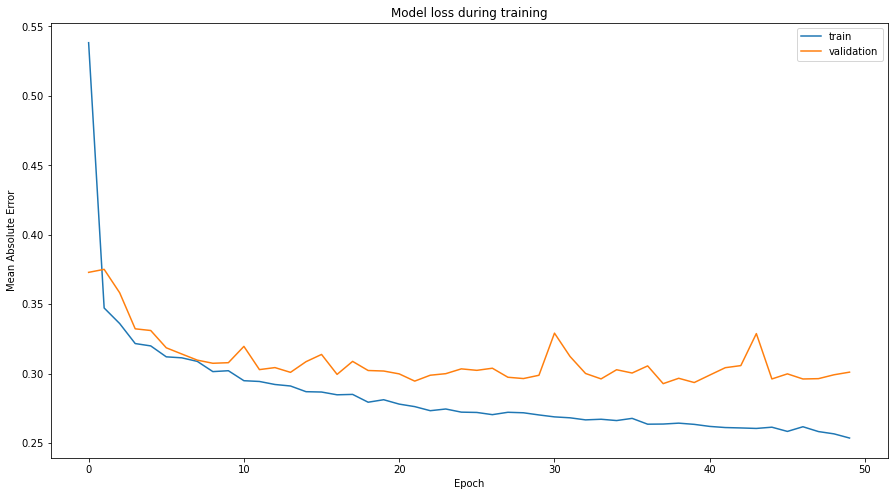

In [9]:
plt.figure(1, figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])

plt.show()